# Statistical Modeling of Diffuse Solar Irradiance from Direct Irradience and Cloud Cover measurements

In [1]:
#IMPORTS
import pandas as pd
import os
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
import pylab as py

print(os.listdir())

['irradience_fitter 3.ipynb', 'data_munger.py', 'Testing_Data', '.DS_Store', 'Untitled.ipynb', 'Data_Viz 2.ipynb', 'irradience_fitter 2.ipynb', 'statistical_modeling.py', 'irradience_fitter.ipynb', 'Raw_Data', 'README.md', 'psm_VA_Charlottesville2018cloud_output.csv', '.ipynb_checkpoints', 'Data_Viz.ipynb', '.git', 'statistical_modeling.ipynb']


In [26]:
#Time for Polynomial Fit
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error, median_absolute_error


In [2]:
_Curr_Dir = os.getcwd()
_Testing_Data_Dir = os.path.join(_Curr_Dir, 'Testing_Data')


In [3]:
def logify_df(df):
    df['DHI_log'] = np.log(df['DHI'])
    df['GHI_log'] = np.log(df['GHI'])
    return df

In [4]:
def make_df_nonzero(df):
    df_no_zero = df.loc[df['DHI']!= 0 ]
    assert len(df_no_zero['DHI'])==len(df_no_zero['GHI']), "Some DHI 0s where GHI is not 0"
    print(df_no_zero)
    return df_no_zero 

In [5]:
def meta_visualization(data, x='GHI', y='DHI', z='Cloud Cover'):
    sns.lmplot(x, y, data=data, hue=z, fit_reg=False)
    plt.show()
    return

In [6]:
def segment_visualization(data, x='GHI', y='DHI', z='Cloud Cover'):
    sns.lmplot(x, y, data=data, hue=z, row=z, fit_reg=True)
    plt.show()
    return

## South Dakota 2018 Data, aka the original data 

In [7]:
#Get 2018 Data
df1_2018 = pd.read_csv(os.path.join(_Testing_Data_Dir, 'psm_testing_data2018.csv'))

In [8]:
print(df1_2018)

      Year  Month  Day  Hour  Minute  Temperature  Clearsky DHI  Clearsky DNI  \
0     2018      1    1     0      30        -22.5             0             0   
1     2018      1    1     1      30        -23.1             0             0   
2     2018      1    1     2      30        -23.6             0             0   
3     2018      1    1     3      30        -23.9             0             0   
4     2018      1    1     4      30        -24.1             0             0   
...    ...    ...  ...   ...     ...          ...           ...           ...   
8755  2018     12   31    19      30        -12.8            60           892   
8756  2018     12   31    20      30        -13.0            52           859   
8757  2018     12   31    21      30        -13.6            41           770   
8758  2018     12   31    22      30        -14.6            26           537   
8759  2018     12   31    23      30        -15.1             0             0   

      Clearsky GHI  Cloud T

In [9]:
#Zeros are removed because it ends up recording hours of night time data
#We dont need to record when sunlight is 0
logify_df(df1_2018)
df1_2018 = make_df_nonzero(df1_2018)

      Year  Month  Day  Hour  Minute  Temperature  Clearsky DHI  Clearsky DNI  \
14    2018      1    1    14      30        -24.4            17           323   
15    2018      1    1    15      30        -22.4            37           762   
16    2018      1    1    16      30        -20.3            48           896   
17    2018      1    1    17      30        -18.5            54           955   
18    2018      1    1    18      30        -17.0            56           976   
...    ...    ...  ...   ...     ...          ...           ...           ...   
8754  2018     12   31    18      30        -12.9            65           889   
8755  2018     12   31    19      30        -12.8            60           892   
8756  2018     12   31    20      30        -13.0            52           859   
8757  2018     12   31    21      30        -13.6            41           770   
8758  2018     12   31    22      30        -14.6            26           537   

      Clearsky GHI  Cloud T

/usr/local/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


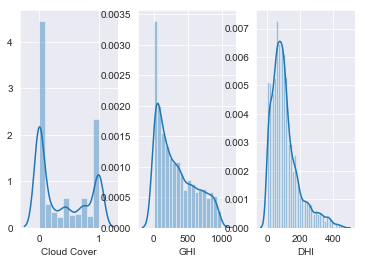

In [10]:
#Take a look at data distribution
sns.set_style('darkgrid')
fig, axs = plt.subplots(ncols=3)
sns.distplot(df1_2018['Cloud Cover'], ax=axs[0])
sns.distplot(df1_2018['GHI'], ax=axs[1])
sns.distplot(df1_2018['DHI'], ax=axs[2])

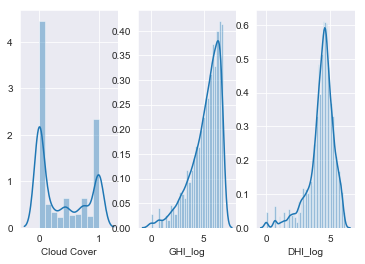

In [27]:
#Take a look at data distribution in logs
sns.set_style('darkgrid')
fig, axs = plt.subplots(ncols=3)
sns.distplot(df1_2018['Cloud Cover'], ax=axs[0])
sns.distplot(df1_2018['GHI_log'], ax=axs[1])
sns.distplot(df1_2018['DHI_log'], ax=axs[2])

In [11]:
"""
Assumptions of Linear Regression:

1.Linearity: The relationship between X and the mean of Y is linear.
    -IE tthe residuals should be normally distributed
2.Homoscedasticity: The variance of residual is the same for any value of X.
3.Independence: Observations are independent of each other.
4.Normality: For any fixed value of X, Y is normally distributed.

""" 

'\nAssumptions of Linear Regression:\n\n1.Linearity: The relationship between X and the mean of Y is linear.\n    -IE tthe residuals should be normally distributed\n2.Homoscedasticity: The variance of residual is the same for any value of X.\n3.Independence: Observations are independent of each other.\n4.Normality: For any fixed value of X, Y is normally distributed.\n\n'

## Polynomial fit with log transform of response 

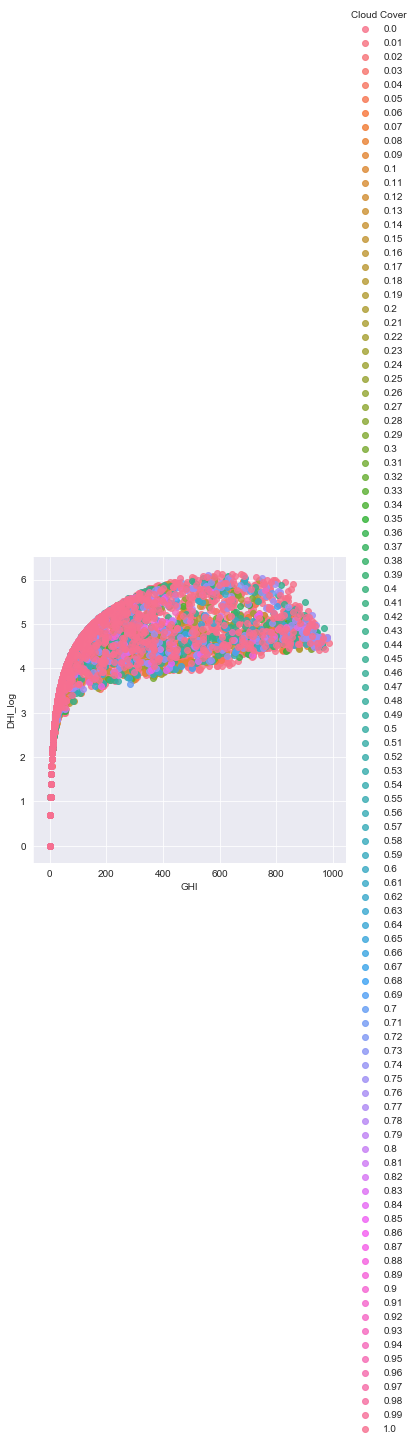

In [12]:
#See the overall data
sns.lmplot('GHI', 'DHI_log', data=df1_2018, hue='Cloud Cover', fit_reg=False)
plt.show()

In [14]:
#Need to fit some poly stuff

#first create X feature vector of [GHI, Cloud Cover]
_GHI = df1_2018['GHI'].values
_Cloud_Cover = df1_2018['Cloud Cover'].values
_X = np.array(list(zip(_GHI, _Cloud_Cover)))

In [15]:
poly = PolynomialFeatures(degree=5)
X_poly = poly.fit_transform(_X)
print(len(X_poly))
log_actuals = df1_2018['DHI_log']

4494


In [16]:
clf_poly = linear_model.LinearRegression()
clf_poly.fit(X_poly, log_actuals)
predictions_poly = clf_poly.predict(X_poly)

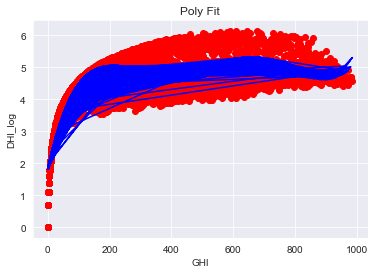

In [17]:
def viz_linear():
    plt.scatter(_GHI, log_actuals, color='red')
    plt.plot(_GHI, predictions_poly, color='blue')
    plt.title('Poly Fit')
    plt.xlabel('GHI')
    plt.ylabel('DHI_log')
    plt.show()
    return
viz_linear()

In [18]:
rmse = np.sqrt(mean_squared_error(log_actuals,predictions_poly))
r2 = r2_score(log_actuals,predictions_poly)
print("rmse is ", rmse)
print("r2 is ",r2)
print("mean absolute error is ",mean_absolute_error(log_actuals,predictions_poly))
print("mean squared log error is ", mean_squared_log_error(log_actuals, predictions_poly))
print("median absolute error is ", median_absolute_error(log_actuals, predictions_poly))
print("MAPE is ", np.mean(np.abs((log_actuals - predictions_poly) / log_actuals)) * 100)

rmse is  0.4991547780071287
r2 is  0.7568685086844883
mean absolute error is  0.39916258513543906
mean squared log error is  0.016365520068935553
median absolute error is  0.3436932169414999
MAPE is  inf


In [19]:
#LEts see how our residuals hold up, lets see if we can wrangle this data

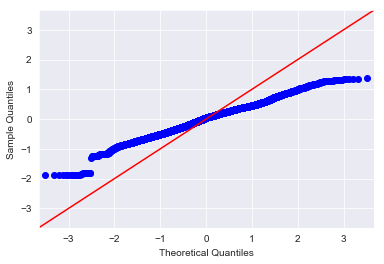

In [20]:
residuals = log_actuals - predictions_poly
sm.qqplot(residuals, line='45')
py.show()

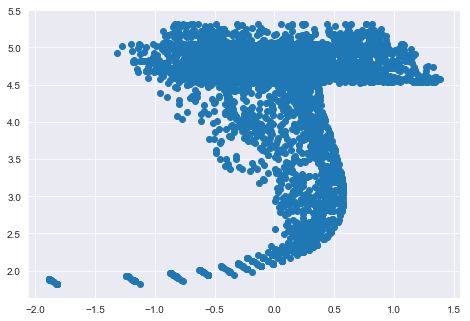

In [21]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(residuals, predictions_poly)
plt.show()

In [22]:
#Residuals are not very normal

In [23]:
"""
For polynomial regression models we assume that:

the behavior of a dependent variable y can be explained by a linear, or curvilinear, additive relationship between the dependent variable and a set of k independent variables (xi, i=1 to k)),
the relationship between the dependent variable y and any independent variable xi is linear or curvilinear (specifically polynomial),
the independent variables xi are independent of each other, and
the errors are independent, normally distributed with mean zero and a constant variance (OLS).
"""

'\nFor polynomial regression models we assume that:\n\nthe behavior of a dependent variable y can be explained by a linear, or curvilinear, additive relationship between the dependent variable and a set of k independent variables (xi, i=1 to k)),\nthe relationship between the dependent variable y and any independent variable xi is linear or curvilinear (specifically polynomial),\nthe independent variables xi are independent of each other, and\nthe errors are independent, normally distributed with mean zero and a constant variance (OLS).\n'

In [24]:
#Problems, problems, problems, we need abetter model!!!

## Log- Log Transform Fitting

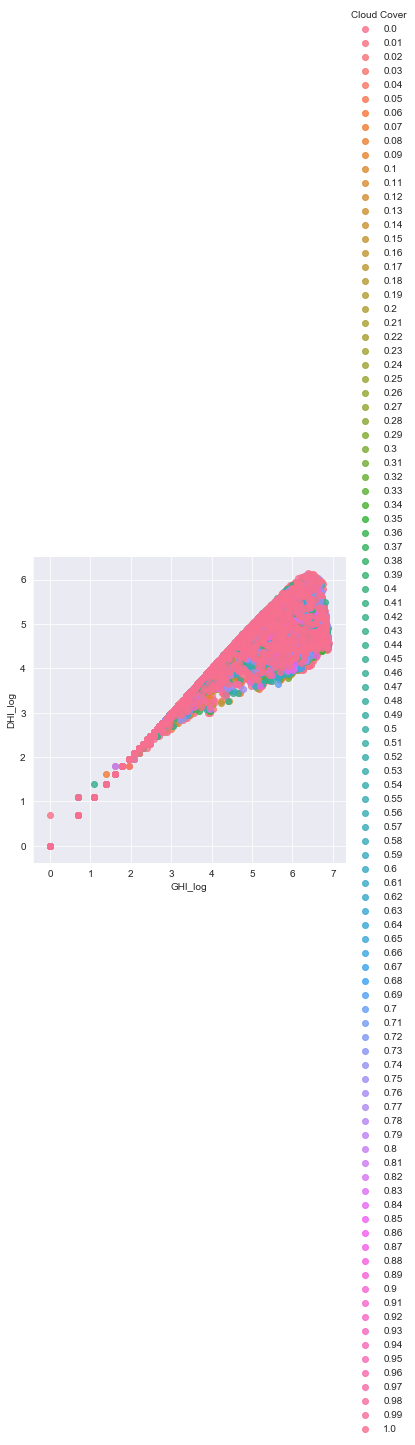

In [25]:
#See the overall data
sns.lmplot('GHI_log', 'DHI_log', data=df1_2018, hue='Cloud Cover', fit_reg=False)
plt.show()

In [56]:
#Fit the linear model
#first create X feature vector of [GHI, Cloud Cover]
_GHI_log = df1_2018['GHI_log'].values
_Cloud_Cover = df1_2018['Cloud Cover'].values
_X_log = np.array(list(zip(_GHI_log, _Cloud_Cover)))
log_actuals = df1_2018['DHI_log']

In [57]:
print(_X_log)
print(_X_log.shape)
print(log_actuals.shape)
#Correct shape

[[2.63905733 0.44      ]
 [4.66343909 1.        ]
 [5.61312811 0.75      ]
 ...
 [5.54907608 1.        ]
 [5.0369526  1.        ]
 [3.91202301 0.99      ]]
(4494, 2)
(4494,)


In [58]:
df1_2018_lin_reg = LinearRegression().fit(_X_log, log_actuals)

In [59]:
df1_2018_lin_reg.coef_

array([0.62767233, 0.3428279 ])

In [60]:
df1_2018_lin_reg.intercept_

0.9351297431441159

In [61]:
#r2 Score
df1_2018_lin_reg.score(_X_log, log_actuals)

0.744334589378747

In [65]:
#Predictions and metrics
predictions_log = df1_2018_lin_reg.predict(_X_log)

In [66]:
rmse = np.sqrt(mean_squared_error(log_actuals,predictions_log))
r2 = r2_score(log_actuals,predictions_log)
print("rmse is ", rmse)
print("r2 is ",r2)
print("mean absolute error is ",mean_absolute_error(log_actuals,predictions_log))
print("mean squared log error is ", mean_squared_log_error(log_actuals, predictions_log))
print("median absolute error is ", median_absolute_error(log_actuals, predictions_log))
print("MAPE is ", np.mean(np.abs((log_actuals - predictions_log) / log_actuals)) * 100)

rmse is  0.5118593177162724
r2 is  0.744334589378747
mean absolute error is  0.4313808973773106
mean squared log error is  0.012859520120319393
median absolute error is  0.41262900659752355
MAPE is  inf


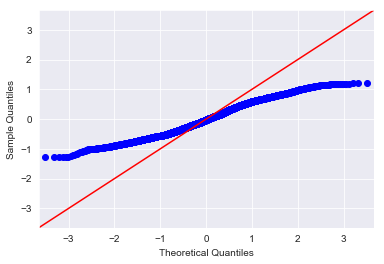

In [67]:
residuals_log = log_actuals - predictions_log
sm.qqplot(residuals_log, line='45')
py.show()

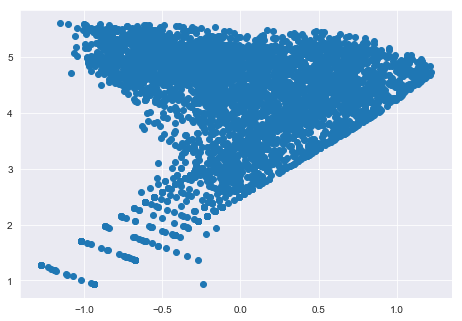

In [68]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(residuals_log, predictions_log)
plt.show()

In [70]:
#Okay none of these are super good. Lets do a boxcox transformation
from sklearn.preprocessing import power_transform

## Power Transform 

In [89]:
box_cox_vector = list(zip(df1_2018['GHI'], df1_2018['Cloud Cover'], df1_2018['DHI']))
box_cox = power_transform(box_cox_vector, method='yeo-johnson')
box_cox_X = list([i[0] for i in box_cox])
box_cox_X2 = list([i[1] for i in box_cox])
box_cox_Y = list([i[2] for i in box_cox])
print(box_cox_X)
print(box_cox_X2)
print(box_cox_Y)
df1_2018['box_cox_X'] = pd.Series(box_cox_X)
df1_2018['box_cox_X2'] = pd.Series(box_cox_X2)
df1_2018['box_cox_Y'] = pd.Series(box_cox_Y)
print(df1_2018)
print(len(df1_2018))

[-1.608115178165106, -0.6564237902200389, 0.1134073322024812, 0.436696321488911, 0.6119679144060186, 0.5670662331074078, 0.35711345700351843, -0.05759381872294776, -0.821629189557112, -1.5267116921769899, -0.3807171628153207, 0.09928921492632571, 0.04146428312098943, -0.25644274314783466, -0.27479874646740815, -0.27018557232957036, -0.47462234558160427, -1.3477575704002918, -1.7046771262199352, -0.9324068668132303, -0.045813654201570304, 0.19217543404444515, 0.2924977424447557, 0.45103592405981174, -0.14710947106332886, -0.4965252139923347, -1.0205482783311957, -1.7321935128422972, -0.7357289170635944, 0.03407695648911768, 0.42223636116654234, 0.4135015153681686, 0.3050017717935124, 0.289356782163511, -0.3266579001526746, -0.8994127983051377, -1.6305628397812642, -0.7153364119890179, -0.4319881453793589, 0.16522697645354634, 0.39589661615965993, 0.3540927908768513, 0.16522697645354634, -0.5416000717969112, -1.1505727253915783, -1.5080888299444428, -0.4584564273937915, 0.130874168101529

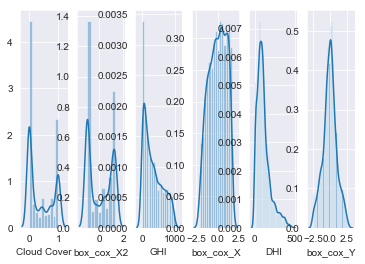

In [90]:
#Take a look at data distribution
sns.set_style('darkgrid')
fig, axs = plt.subplots(ncols=6)
sns.distplot(df1_2018['Cloud Cover'], ax=axs[0])
sns.distplot(df1_2018['box_cox_X2'], ax=axs[1])
sns.distplot(df1_2018['GHI'], ax=axs[2])
sns.distplot(df1_2018['box_cox_X'], ax=axs[3])
sns.distplot(df1_2018['DHI'], ax=axs[4])
sns.distplot(df1_2018['box_cox_Y'], ax=axs[5])

In [91]:
#Distributions are much more normal

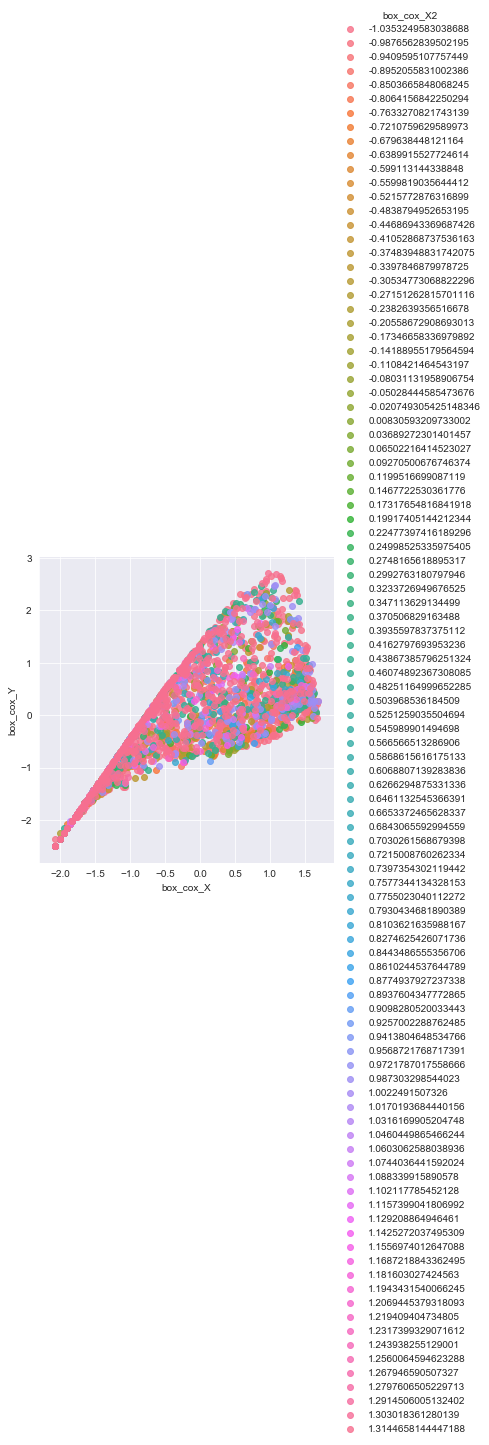

In [92]:
#See the overall data
sns.lmplot('box_cox_X', 'box_cox_Y', data=df1_2018, hue='box_cox_X2', fit_reg=False)
plt.show()

In [93]:
#Still heteroskedastic, whatever, lets fit a curve

In [104]:
#Fit the linear model
#first create X feature vector of [GHI, Cloud Cover]
_ptrans_X1 = df1_2018['box_cox_X'].values
_ptrans_X2 = df1_2018['box_cox_X2'].values
_ptrans_X = np.array(list(zip(_ptrans_X1, _ptrans_X2)))
ptrans_actuals = df1_2018['box_cox_Y'].values

[ 0.65538988  0.30722078 -0.08408252 ...         nan         nan
         nan]
4494


In [105]:
df2018_ptransform_lin_reg = LinearRegression().fit(_ptrans_X, ptrans_actuals)
df2018_ptransform_lin_reg.score(_ptrans_X, ptrans_actuals)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
#Transformations yield too many NaN values. Until a solution found for this, this is the end of the road
